In [ ]:
%matplotlib inline


# Comparing different auto-k clustering algorithms with SEAT on toy datasets

This example shows characteristics of different
auto-k clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


Automatically created module for IPython interactive environment
fit bottom_up
sigma 20
i 5401 (linkage - initial non zero pair)
----- SE merge phase 0 True start, individuals:  1000 , leaves  1000
6401
----- SE merge phase 0 end, individuals 0 , leaves  27
i 15778 merge phase
i 15805 merge phase update leaves states
----- SE binary merge 1
i 16481 binary_combine
N 1000 i 16481
build tree time 1.4803898334503174
se cost
[       nan 9.96577763 9.46628382 9.46596012 9.46690364 9.49018371
 9.494944   9.50493059 9.51585932 9.5327212  9.54515874]
9.465960115931999
fit top_down
sigma 20
build tree time 0.49344515800476074
se cost
[       nan 9.96577763 9.46628382 9.46574616 9.46530996 9.49572645
 9.50996661 9.51571544 9.52338301 9.53815291 9.54454994]
9.465309963301246
fit bottom_up
sigma 20
i 5510 (linkage - initial non zero pair)
----- SE merge phase 0 True start, individuals:  1000 , leaves  1000
6510
----- SE merge phase 0 end, individuals 0 , leaves  25
i 16278 merge phase
i 16303 merge

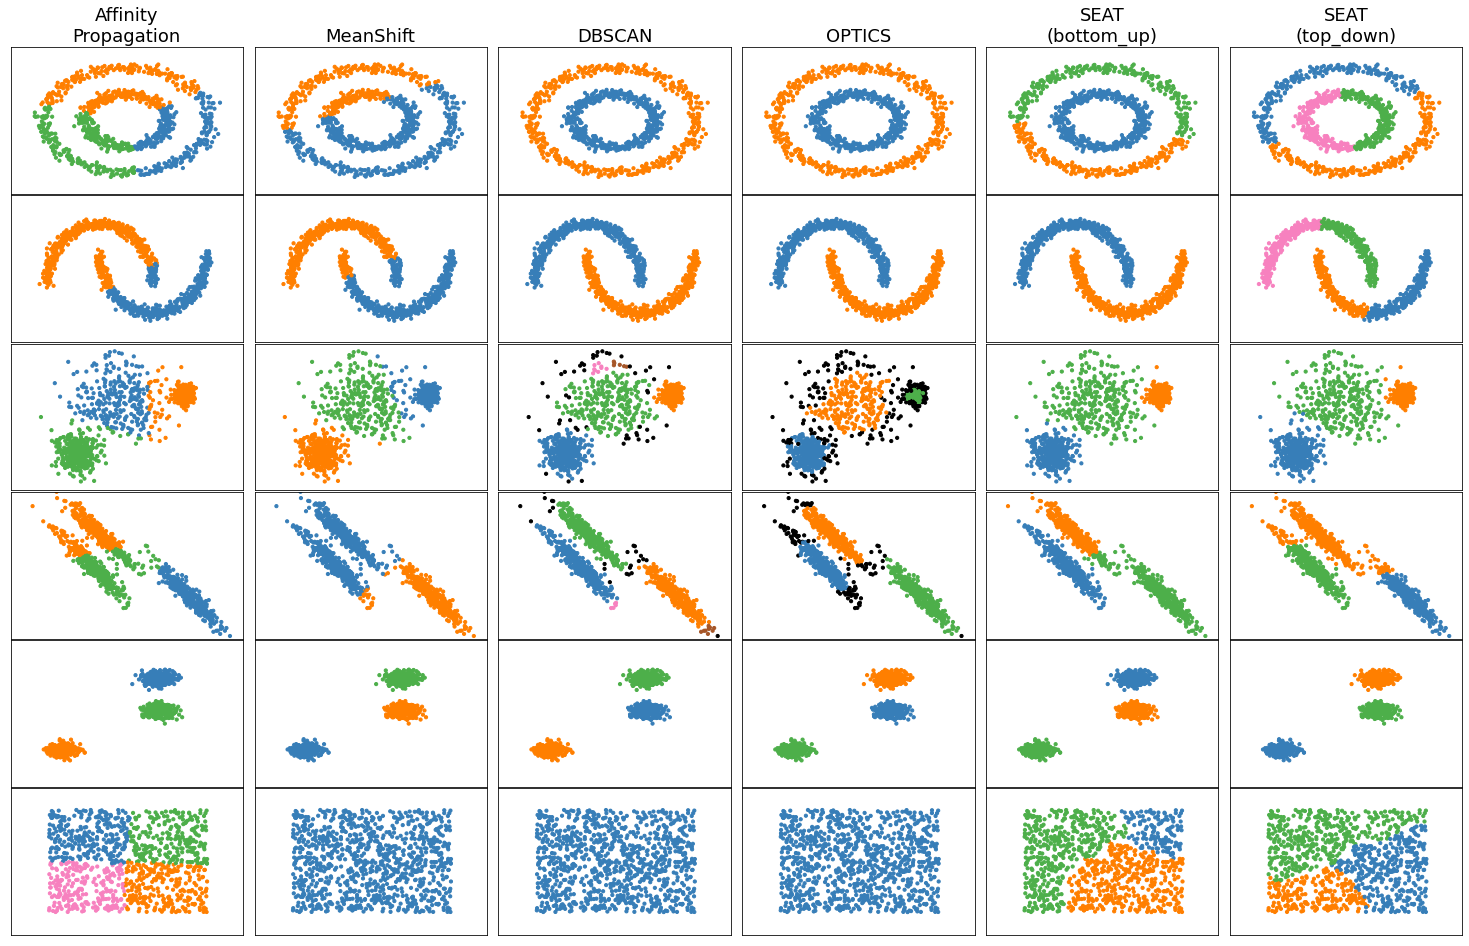

In [22]:
print(__doc__)

import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from pyseat.SEAT import SEAT

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'],
        random_state=0)
    gamma = 20
    bottom_up = SEAT(affinity="gaussian_kernel",
                     kernel_gamma=gamma,
            sparsification="knn_neighbors",
            objective="SE",
            strategy="bottom_up")
    
    top_down = SEAT(affinity="gaussian_kernel",
                    kernel_gamma=gamma,
            sparsification="knn_neighbors",
            objective="SE",
            strategy="top_down")
    
    
    clustering_algorithms = (
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('SEAT\n(bottom_up)', bottom_up),
        ('SEAT\n(top_down)', top_down)
    )

    for name, algorithm in clustering_algorithms:

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)

            if 'SEAT' not in name:
                algorithm.fit(X)
            else:
                algorithm.fit_predict(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

# Comparing different predefined-k clustering algorithms with SEAT on toy datasets

This example shows characteristics of different
predefined-k clustering algorithms on the toy datasets.

Automatically created module for IPython interactive environment
fit bottom_up
sigma 1.0
i 5401 (linkage - initial non zero pair)
----- SE merge phase 0 True start, individuals:  1000 , leaves  1000
6401
----- SE merge phase 0 end, individuals 0 , leaves  27
i 15778 merge phase
i 15805 merge phase update leaves states
----- SE binary merge 1
i 16481 binary_combine
N 1000 i 16481
build tree time 1.4719691276550293
se cost
[       nan 9.91155588 9.27722127 9.01769117 8.85703143 8.74651971
 8.67772859 8.63901442 8.63197875 8.63062016 8.63823484]
8.630620157992402
fit top_down
sigma 1.0
build tree time 0.5058441162109375
se cost
[       nan 9.91155588 9.27722127 8.99495576 8.83443418 8.77241155
 8.71769744 8.66694611 8.62250006 8.62429036 8.62851349]
8.622500060095518
fit bottom_up
sigma 0.9999999999999998
i 5510 (linkage - initial non zero pair)
----- SE merge phase 0 True start, individuals:  1000 , leaves  1000
6510
----- SE merge phase 0 end, individuals 0 , leaves  25
i 16278 merge ph

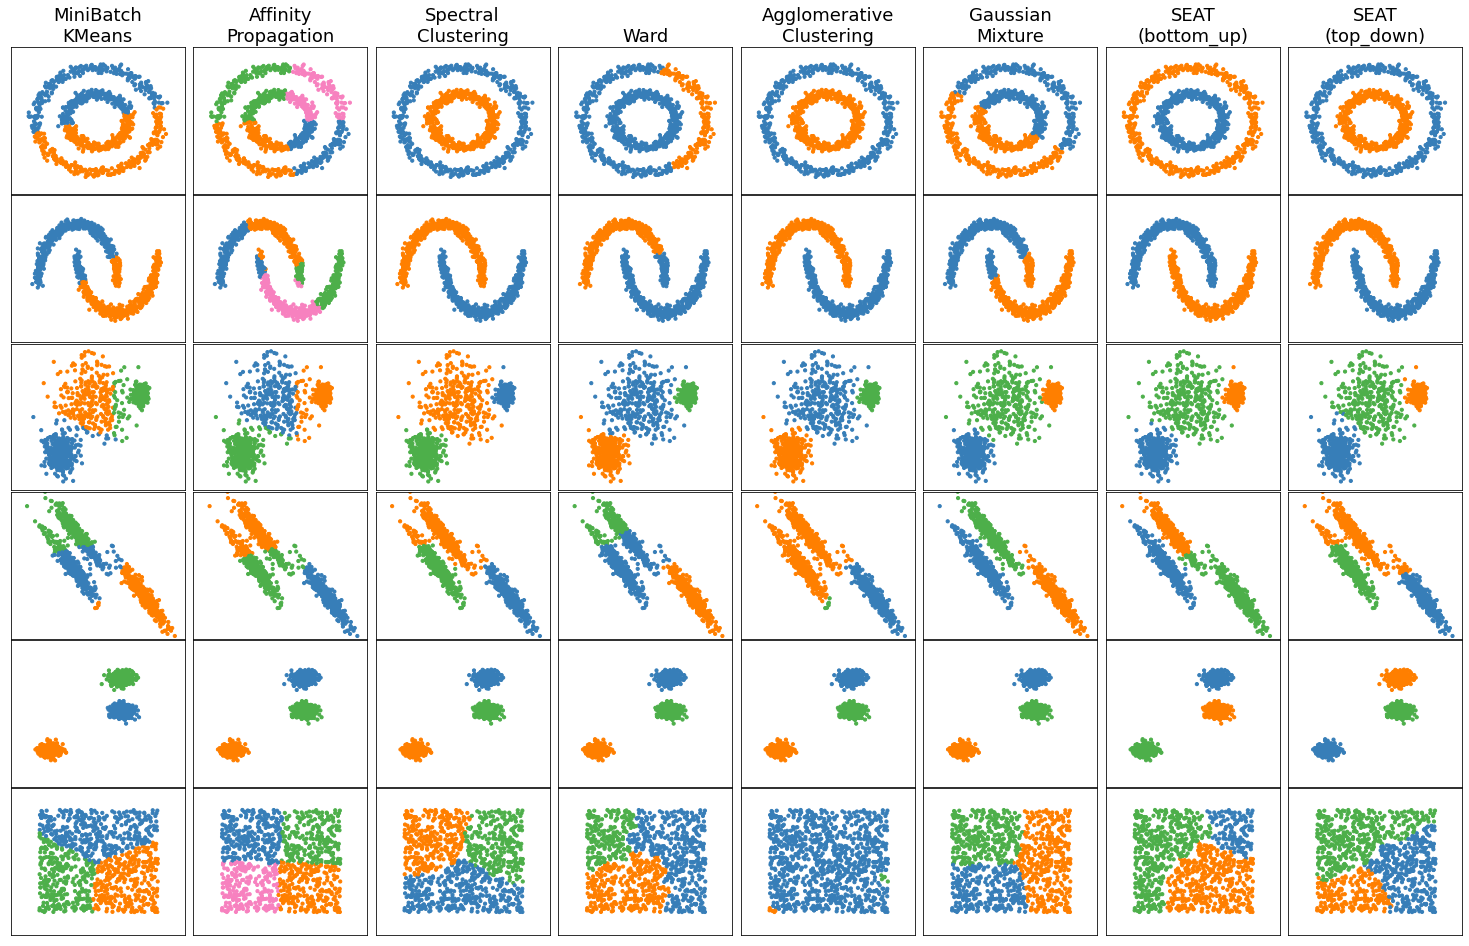

In [21]:
print(__doc__)

import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from pyseat.SEAT import SEAT

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    bottom_up = SEAT(affinity="gaussian_kernel",
            sparsification="knn_neighbors",
            objective="SE",
            strategy="bottom_up")
    
    top_down = SEAT(affinity="gaussian_kernel",
            sparsification="knn_neighbors",
            objective="SE",
            strategy="top_down")
    
    
    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('Gaussian\nMixture', gmm),
        ('SEAT\n(bottom_up)', bottom_up),
        ('SEAT\n(top_down)', top_down)
    )

    for name, algorithm in clustering_algorithms:

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)

            if 'SEAT' not in name:
                algorithm.fit(X)
            else:
                algorithm.fit_predict(X)

        if 'SEAT' in name:
            y_pred = algorithm.ks_clusters['K={}'.format(params['n_clusters'])].to_list()
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()